In [1]:
import json
import pandas as pd
import sys
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import numpy as np

In [2]:
consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXX-XXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [3]:
class SListener(StreamListener):
    def __init__(self, api = None):
        self.api = api or API()
        self.counter = 0
        self.output  = open('streamer.json', 'w' , encoding="utf-8")


    def on_data(self, data):
        if  'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return


    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 200:
            self.output.close()
            #self.output  = open('streamer.json', 'w', encoding="utf-8")
            #self.counter = 0
        return


    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return


    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return


    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 


    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 


In [4]:
# Consumer key authentication
auth = OAuthHandler(consumer_key, consumer_secret)

# Access key authentication
auth.set_access_token(access_token, access_token_secret)

# Set up the API with the authentication handler
api = API(auth)

In [5]:
# Set up words to track
keywords_to_track = ['#python', '#rstats']

# Instantiate the SListener object 
listen = SListener(api)

# Instantiate the Stream object
stream = Stream(auth, listen)

# Begin collecting data
stream.filter(track = keywords_to_track)
    
#stream.sample()

ValueError: I/O operation on closed file.

In [6]:
def flatten_tweets(tweets_json):
    tweets = []
    
    ## parse each tweet
    for tweet in tweets_json:
        try:
            tweet_obj = json.loads(tweet)

            # Store the user screen name in 'user-screen_name'
            tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
            tweet_obj['user-location'] = tweet_obj['user']['location']
            # Check if this is a 140+ character tweet
            if 'extended_tweet' in tweet_obj:
                # Store the extended tweet text in 'extended_tweet-full_text'
                tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
            if 'retweeted_status' in tweet_obj:
                # Store the retweet user screen name in 'retweeted_status-user-screen_name'
                tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
            
            ## flatten the file to include quoted status and retweeted status info
            if 'quoted_status' in tweet_obj:
                tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
                tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']

            if 'retweeted_status' in tweet_obj:
                tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
                tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
            
            tweets.append(tweet_obj)
        except:
            pass
    return tweets

In [7]:
fh = open('streamer.json', 'r', encoding = 'utf-8')
tweets_json = fh.read().split("\n")

In [8]:
tweets = flatten_tweets(tweets_json)

In [9]:
df_tweet = pd.DataFrame(tweets)


In [10]:
print(df_tweet.columns)


Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'extended_tweet',
       'extended_tweet-full_text', 'favorite_count', 'favorited',
       'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status-text', 'quoted_status-user-screen_name',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'retweeted_status-text', 'retweeted_status-user-screen_name', 'source',
       'text', 'timestamp_ms', 'truncated', 'user', 'user-location',
       'user-screen_name'],
      dtype='object')


In [11]:
print(df_tweet['text'].values[0:5])

['Software Defined Network and the OpenFlow Protocol a Pratical Setup with Python https://t.co/cQGoaTxZVS #python'
 'De Linux a Python: iníciate en el mundo del hacking ético con este curso gratuito de 15 horas para principiantes… https://t.co/RLngu9E8lq'
 'RT @mahomes_tech: Make sure to follow our hosting provider @a2hosting they’re the best hosting provider in contemporary times! #javascript…'
 '#ICYMI - Are you struggling with common #Python challenges?\n\nMinimize the need to script, simplify the use of compl… https://t.co/KixINy2Jbw'
 'RT @pythonlangbot: How to compute count rule in python dataframe? (Similar to count if in SQL) https://t.co/CrE5r635mn #python']


In [12]:
# Find mentions of #python in 'text'
python = df_tweet['text'].str.contains('#python', case = False)

In [13]:
# Find mentions of #rstats in 'text'
rstats = df_tweet['text'].str.contains('#rstats', case = False)

In [14]:
# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / df_tweet.shape[0])

Proportion of #python tweets: 0.38


In [15]:
# Print proportion of tweets mentioning #python
print("Proportion of #rstats tweets:", np.sum(rstats) / df_tweet.shape[0])

Proportion of #rstats tweets: 0.125


In [16]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False) 
    #contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False) 
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False) 
    #contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

In [17]:
# Find mentions of #python in all text fields
python = check_word_in_tweet('#python', df_tweet)

In [19]:
# Find mentions of #python in all text fields
python = check_word_in_tweet('#rstats', df_tweet)

In [20]:
df_tweet['created_at'] = pd.to_datetime(df_tweet['created_at'])

In [21]:
df_tweet = df_tweet.set_index('created_at')

In [22]:
df_tweet['python'] = check_word_in_tweet('python', df_tweet)
df_tweet['rstats'] = check_word_in_tweet('rstats', df_tweet)

In [23]:
print(np.sum(df_tweet['python']))
print(np.sum(df_tweet['rstats']))

105
33


In [24]:
mean_python = df_tweet['python'].resample('1 min').mean()

In [25]:
mean_rstats = df_tweet['rstats'].resample('1 min').mean()

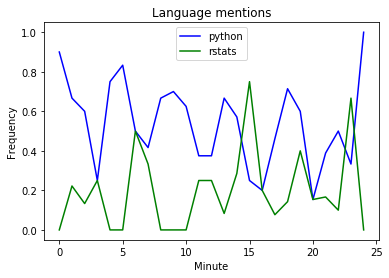

In [27]:
import matplotlib.pyplot as plt 

plt.plot(mean_python.index.minute, 
    mean_python, color = 'blue')
plt.plot(mean_rstats.index.minute, 
    mean_rstats, color = 'green')
plt.xlabel('Minute')
plt.ylabel('Frequency')
plt.title('Language mentions')
plt.legend(('python', 'rstats'))
plt.show()

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores = df_tweet['text'].apply(sid.polarity_scores)

In [29]:
sentiment = sentiment_scores.apply(lambda x: x['compound'])
sentiment_py = sentiment[check_word_in_tweet('python', df_tweet)].resample('1 min').mean()
sentiment_rt = sentiment[check_word_in_tweet('rstats', df_tweet)].resample('1 min').mean()

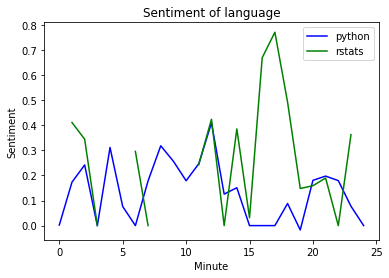

In [30]:
plt.plot(sentiment_py.index.minute, 
       sentiment_py, color = 'blue')
plt.plot(sentiment_rt.index.minute, 
       sentiment_rt, color = 'green')

plt.xlabel('Minute')
plt.ylabel('Sentiment')
plt.title('Sentiment of language')
plt.legend(('python', 'rstats'))
plt.show()

In [31]:
import networkx as nx
## ... flatten and convert JSON
G_rt = nx.from_pandas_edgelist(
                        df_tweet,
                        source = 'user-screen_name', 
                        target = 'retweeted_status-user-screen_name',
                        create_using = nx.DiGraph())

In [32]:
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 175
Edges in RT network: 167


In [33]:
## ... flatten and convert JSON
G_quote = nx.from_pandas_edgelist(
                           df_tweet,
                           source = 'user-screen_name', 
                           target = 'quoted_status-user-screen_name',
                           create_using = nx.DiGraph())

In [34]:
# Print the number of nodes
print('Nodes in quoted network:', len(G_quote.nodes()))

# Print the number of edges
print('Edges in quoted network:', len(G_quote.edges()))

Nodes in quoted network: 144
Edges in quoted network: 143


In [35]:
## ... flatten and convert JSON

G_reply = nx.from_pandas_edgelist(
                           df_tweet,
                           source = 'user-screen_name', 
                           target = 'in_reply_to_screen_name',
                           create_using = nx.DiGraph())


In [36]:
# Print the number of nodes
print('Nodes in reply network:', len(G_reply.nodes()))

# Print the number of edges
print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 141
Edges in reply network: 140


c:\users\gaurav\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\users\gaurav\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


(-0.2523168119460487,
 1.118998430094421,
 -1.0683042543000942,
 0.24628698516849432)

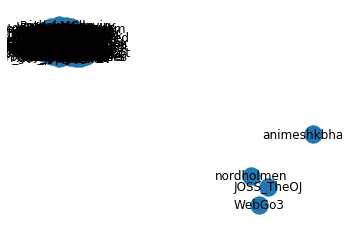

In [37]:
nx.draw_networkx(G_reply)
plt.axis('off')

In [38]:
sizes = [x[1]*100 for x in G_rt.degree()]

(-0.8711170161764396,
 0.8856468668217843,
 -1.1550870079140931,
 0.6566973330235589)

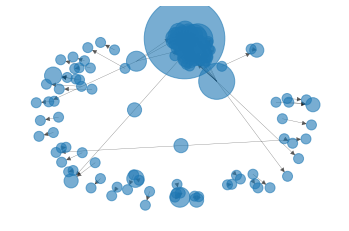

In [39]:

nx.draw_networkx(G_rt, 
                node_size = sizes, 
                with_labels = False, 
                alpha = 0.6,
                width = 0.3)
plt.axis('off')

(-1.2108103458661696,
 1.2307391036470474,
 -1.209951246191313,
 1.2099512365694203)

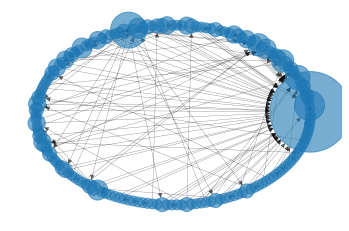

In [40]:
#Circular layout
circle_pos =nx.circular_layout(G_rt)
nx.draw_networkx(G_rt,
                pos = circle_pos,
                node_size = sizes, 
                with_labels = False, 
                alpha = 0.6,
                width = 0.3)
plt.axis('off')

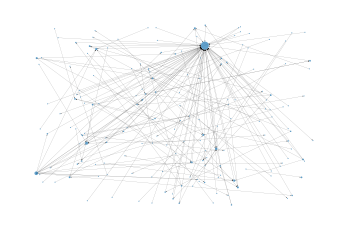

In [41]:
# Create random layout positions
pos = nx.random_layout(G_rt)

# Create size list
sizes = [x[1] for x in G_rt.degree()]

# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

In [42]:
column_names = ['screen_name', 'degree_centrality']

In [43]:
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Generate in-degree centrality for replies 
reply_centrality = nx.in_degree_centrality(G_reply)

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('degree_centrality', ascending = False).head())

     screen_name  degree_centrality
1            NaN           0.373563
3   mahomes_tech           0.040230
12  PythonWeekly           0.028736
25     dataandme           0.022989
18   yimregister           0.022989
        screen_name  degree_centrality
1              None           0.971429
50   animeshkbhadra           0.007143
56     TivadarDanka           0.007143
110      JOSS_TheOJ           0.007143
111          WebGo3           0.007143


In [44]:
column_names = ['screen_name', 'betweenness_centrality']

In [45]:
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)



In [46]:
# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)



In [47]:
# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('betweenness_centrality', ascending = False).head())

     screen_name  betweenness_centrality
3   mahomes_tech                0.000177
12  PythonWeekly                0.000149
25     dataandme                0.000103
23    cs_savings                0.000100
18   yimregister                0.000081
        screen_name  betweenness_centrality
0      pythonhourly                     0.0
97         pdgjones                     0.0
91  ChasingMicrobes                     0.0
92   tensorflownewz                     0.0
93      tensorflowz                     0.0


In [48]:
column_names = ['screen_name', 'degree']

In [49]:
# Calculate in-degrees and store in DataFrame
degree_rt = pd.DataFrame(list(G_rt.in_degree()), columns = column_names)
degree_reply = pd.DataFrame(list(G_reply.in_degree()), columns = column_names)

# Merge the two DataFrames on screen name
ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))

# Calculate the ratio
ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

# Exclude any tweets with less than 5 retweets
ratio = ratio[ratio['degree_rt'] >= 5]

# Print out first five with highest ratio
print(ratio.sort_values('ratio', ascending = False).head())

     screen_name  degree_rt  degree_reply     ratio
1            NaN         65           136  2.092308
3   mahomes_tech          7             0  0.000000
11  PythonWeekly          5             0  0.000000


In [50]:
# Print out the location of a single tweet
#print(tweet_json['user']['location'])

# Flatten and load the SOTU tweets into a dataframe
#tweets_sotu = pd.DataFrame(flatten_tweets(tweets_sotu_json))

# Print out top five user-defined locations
print(df_tweet['user-location'].value_counts().head())

Bahrain                           11
Chicago, IL                        6
Bengaluru, India                   5
Earth                              4
https://compute-hole.woolweave     4
Name: user-location, dtype: int64


In [51]:
def getBoundingBox(place):
    """ Returns the bounding box coordinates."""
    return place['bounding_box']['coordinates']



In [52]:
fh = open('streamer.json', 'r', encoding = 'utf-8')
tweets_json = fh.read().split("\n")
tweets = flatten_tweets(tweets_json)
df_tweet = pd.DataFrame(tweets)


In [53]:
df_tweet['place']

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
170    None
171    None
172    None
173    None
174    None
175    None
176    None
177    None
178    None
179    None
180    None
181    None
182    None
183    None
184    None
185    None
186    None
187    None
188    None
189    None
190    None
191    None
192    None
193    None
194    None
195    None
196    None
197    None
198    None
199    None
Name: place, Length: 200, dtype: object

In [54]:
# Apply the function which gets bounding box coordinates
bounding_boxes = df_tweet['place'].apply(getBoundingBox)

TypeError: 'NoneType' object is not subscriptable

In [139]:
# Print out the first bounding box coordinates
print(bounding_boxes.values[0])

[[[22.13572, 44.386383], [22.13572, 52.379475], [40.227172, 52.379475], [40.227172, 44.386383]]]


In [142]:
def calculateCentroid(place):
    """ Calculates the centroid from a bounding box."""
    # Obtain the coordinates from the bounding box.
    coordinates = place['bounding_box']['coordinates'][0]
    
    longs = np.unique( [x[0] for x in coordinates] )
    lats  = np.unique( [x[1] for x in coordinates] )
    
    if len(longs) == 1 and len(lats) == 1:
        # return a single coordinate
        return (longs[0], lats[0])
    elif len(longs) == 2 and len(lats) == 2:
        # If we have two longs and lats, we have a box.
        central_long = np.sum(longs) / 2
        central_lat  = np.sum(lats) / 2
    else:
        raise ValueError("Non-rectangular polygon not supported.")

    return (central_long, central_lat)

# Calculate the centroids of place     
centroids = df_tweet['place'].apply(calculateCentroid)

In [143]:
print(centroids)

0    (31.181446, 48.382929000000004)
Name: place, dtype: object


In [144]:
# Import Basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt



In [145]:
# Set up the US bounding box
us_boundingbox = [-125, 22, -64, 50] 

# Set up the Basemap object
m = Basemap(llcrnrlon = us_boundingbox[0],
            llcrnrlat = us_boundingbox[1],
            urcrnrlon = us_boundingbox[2],
            urcrnrlat = us_boundingbox[3],
            projection='merc')

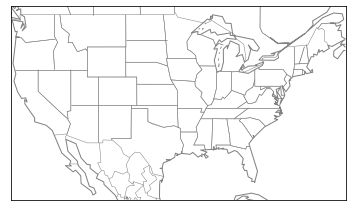

In [146]:
# Calculate the centroids for the dataset 
# and isolate longitudue and latitudes
centroids = df_tweet['place'].apply(calculateCentroid)
lon = [x[0] for x in centroids]
lat = [x[1] for x in centroids]

# Draw continents, coastlines, countries, and states
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Draw the points and show the plot
m.scatter(lon, lat, latlon = True, alpha = 0.7)
plt.show()

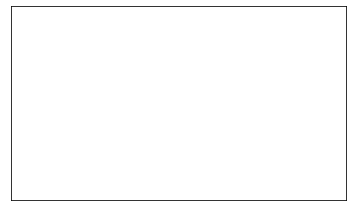

In [147]:
# Generate sentiment scores
sentiment_scores = df_tweet['text'].apply(sid.polarity_scores)

# Isolate the compound element
sentiment_scores = [x['compound'] for x in sentiment_scores]

# Draw the points
m.scatter(lon, lat, latlon = True, 
           c = sentiment_scores,
           cmap = 'coolwarm', alpha = 0.7)

# Show the plot
plt.show()